In [1]:
from orion import Orion
from orion.evaluation.contextual import contextual_accuracy, contextual_f1_score, contextual_precision
import pandas as pd
from output_utils.utils import plot
from supporting_func.supporting_func import split_data, save_model, load_model, print_anomalies, convert_dfdatetotime, convert_dftimetodate
from global_variables.global_variables import filename_train, all_activities, filename_test, filename_summary
from orion.primitives.tadgan import TadGAN

Using TensorFlow backend.


In [2]:
    pickle_file = "sleep_model.pickle"

    # df = pd.read_csv(filename_train)
    # dict_dfs = split_data(df,30)
    # training_df = dict_dfs[0][all_activities]
    # test_df = dict_dfs[1][all_activities]

    # test_df = test_df[all_activities]
    # parameters = {
    #     "mlprimitives.custom.timeseries_preprocessing.time_segments_aggregate#1": {
    #         "interval": 300 # 5min
    #     },
    #     'orion.primitives.tadgan.TadGAN#1': {
    #         'epochs': 30,
    #         'latent_dim': 50,
    #         'dense_units': 50,
    #     }
    # }
    # orion = Orion(pipeline='config/tadgan.json', hyperparameters=parameters)
    # orion.fit(test_df)

In [3]:
    # # load and read files - detect anomalies
    # df = pd.read_csv(filename_test)
    # df = df[all_activities]
    # orion = load_model(pickle_file)
    # # print(dir(orion._mlpipeline.predict))
    # prediction,  = orion._mlpipeline.predict(df)
    # print(prediction)

In [4]:
    
    df = pd.read_csv(filename_train)
    df = df[all_activities]

In [5]:
import json
import numpy as np
import matplotlib.pyplot as plt
#importing sklearn module
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
#utils.py contains all the plot function.
# from utils import plot, plot_ts, plot_rws, plot_error, unroll_ts

with open("config/tadgan.json") as f:
  primitives = json.load(f)["primitives"]
print(primitives) 

['mlprimitives.custom.timeseries_preprocessing.time_segments_aggregate', 'sklearn.impute.SimpleImputer', 'sklearn.preprocessing.MinMaxScaler', 'mlprimitives.custom.timeseries_preprocessing.rolling_window_sequences', 'orion.primitives.timeseries_preprocessing.slice_array_by_dims', 'orion.primitives.tadgan.TadGAN', 'orion.primitives.tadgan.score_anomalies', 'orion.primitives.timeseries_anomalies.find_anomalies']


In [6]:
def time_segments_aggregate(X, interval, time_column, method=['mean']):
    """Aggregate values over given time span.
    Args:
        X (ndarray or pandas.DataFrame):
            N-dimensional sequence of values.
        interval (int):
            Integer denoting time span to compute aggregation of.
        time_column (int):
            Column of X that contains time values.
        method (str or list):
            Optional. String describing aggregation method or list of strings describing multiple
            aggregation methods. If not given, `mean` is used.
    Returns:
        ndarray, ndarray:
            * Sequence of aggregated values, one column for each aggregation method.
            * Sequence of index values (first index of each aggregated segment).
    """
    #checking for the input datatype as numpy array and converting it to dataframe
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
    #sorting the values on timestamp column and setting it as a index
    X = X.sort_values(time_column).set_index(time_column)

    if isinstance(method, str):
        method = [method]

    start_ts = X.index.values[0]
    max_ts = X.index.values[-1]

    values = list()
    index = list()
    while start_ts <= max_ts:
        end_ts = start_ts + interval
        subset = X.loc[start_ts:end_ts - 1]
        aggregated = [
            getattr(subset, agg)(skipna=True).values
            for agg in method
        ]
        values.append(np.concatenate(aggregated))
        index.append(start_ts)
        start_ts = end_ts

    return np.asarray(values), np.asarray(index)
#here df is the given dataframe and "timestamp" is the required column to be altered.
X, index = time_segments_aggregate(df, interval=60, time_column='timestamp')

In [7]:
#Using the simple scikit imputer
imp = SimpleImputer()
X = imp.fit_transform(X)

In [8]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

In [9]:
def rolling_window_sequences(X, index, window_size, target_size, step_size, target_column,
                             drop=None, drop_windows=False):
    """Create rolling window sequences out of time series data.
    The function creates an array of input sequences and an array of target sequences by rolling
    over the input sequence with a specified window.
    Optionally, certain values can be dropped from the sequences.
    Args:
        X (ndarray):
            N-dimensional sequence to iterate over.
        index (ndarray):
            Array containing the index values of X.
        window_size (int):
            Length of the input sequences.
        target_size (int):
            Length of the target sequences.
        step_size (int):
            Indicating the number of steps to move the window forward each round.
        target_column (int):
            Indicating which column of X is the target.
        drop (ndarray or None or str or float or bool):
            Optional. Array of boolean values indicating which values of X are invalid, or value
            indicating which value should be dropped. If not given, `None` is used.
        drop_windows (bool):
            Optional. Indicates whether the dropping functionality should be enabled. If not
            given, `False` is used.
    Returns:
        ndarray, ndarray, ndarray, ndarray:
            * input sequences.
            * target sequences.
            * first index value of each input sequence.
            * first index value of each target sequence.
    """
    out_X = list()
    out_y = list()
    X_index = list()
    y_index = list()
    target = X[:, target_column]

    if drop_windows:
        if hasattr(drop, '__len__') and (not isinstance(drop, str)):
            if len(drop) != len(X):
                raise Exception('Arrays `drop` and `X` must be of the same length.')
        else:
            if isinstance(drop, float) and np.isnan(drop):
                drop = np.isnan(X)
            else:
                drop = X == drop

    start = 0
    max_start = len(X) - window_size - target_size + 1
    while start < max_start:
        end = start + window_size

        if drop_windows:
            drop_window = drop[start:end + target_size]
            to_drop = np.where(drop_window)[0]
            if to_drop.size:
                start += to_drop[-1] + 1
                continue

        out_X.append(X[start:end])
        out_y.append(target[end:end + target_size])
        X_index.append(index[start])
        y_index.append(index[end])
        start = start + step_size

    return np.asarray(out_X), np.asarray(out_y), np.asarray(X_index), np.asarray(y_index)
#the target value; the value at time t.
#previous observed values, this is determined by the window width.
X, y, X_index, y_index = rolling_window_sequences(X, index, 
                                                  window_size=100, 
                                                  target_size=1, 
                                                  step_size=1,
                                                  target_column=0)

In [10]:
print("Training data input shape: {}".format(X.shape))
print("Training data index shape: {}".format(X_index.shape))
print("Training y shape: {}".format(y.shape))
print("Training y index shape: {}".format(y_index.shape))

Training data input shape: (85652, 100, 1)
Training data index shape: (85652,)
Training y shape: (85652, 1)
Training y index shape: (85652,)


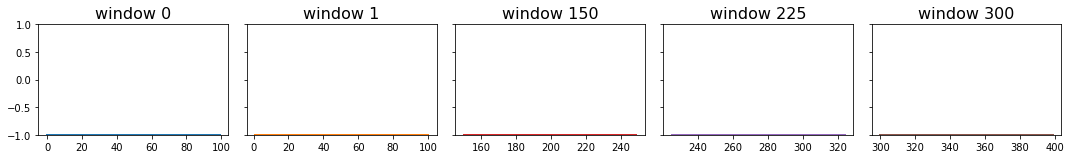

In [11]:
from output_utils.utils import plot, plot_ts, plot_rws, plot_error, unroll_ts
#function from utils.py module. Representing all the windows that has been created by slicing
#Here X represents the input used to train the model. In the previous example, we see X has 10222 training data points.
#Notice that 100 represents the window size. On the other hand, y is the real signal after processing, 
#which we will use later on to calculate the error between the reconstructed and real signal.
plot_rws(X, 100)

In [12]:
from config.model import hyperparameters
from orion.primitives.tadgan import TadGAN

hyperparameters["epochs"] = 35
hyperparameters["shape"] = (100, 1) # based on the window size
hyperparameters["optimizer"] = "keras.optimizers.Adam"
hyperparameters["learning_rate"] = 0.0005
hyperparameters["latent_dim"] = 20
hyperparameters["batch_size"] = 64

tgan = TadGAN(**hyperparameters)
tgan.fit(X)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/Users/hall/Dropbox/Imperial/Individual-project/individual-project/.venv/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
2022-08-05 16:27:36.994395: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-08-05 16:27:37.027676: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa2009cf780 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-05 16:27:37.027692: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


/Users/hall/Dropbox/Imperial/Individual-project/individual-project/.venv/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/hall/Dropbox/Imperial/Individual-project/individual-project/.venv/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
2022-08-05 16:27:54.716701: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:697] Iteration = 0, topological sort failed with message: The graph couldn't be sorted in topological order.
2022-08-05 16:27:54.750785: E tensorflow/core/grappler/optimizers/dependency_optimizer.cc:697] Iter

Epoch: 1/35, [Dx loss: [-0.98563564 -5.08036     3.6146421   0.04800872]] [Dz loss: [-2.5989091  -1.2736619  -1.9597181   0.06344667]] [G loss: [ 0.44746172 -3.5276089   2.3249023   0.16501714]]
Epoch: 2/35, [Dx loss: [-0.48200518  1.894649   -2.5538104   0.01771569]] [Dz loss: [-2.6180804  -2.868402   -0.1689893   0.04193065]] [G loss: [3.7489605  2.740942   0.27098396 0.07370348]]
Epoch: 3/35, [Dx loss: [-3.4991392e-01  2.2796377e+01 -2.3292580e+01  1.4630787e-02]] [Dz loss: [-2.7293963 -4.4009404  1.2193145  0.0452229]] [G loss: [22.892385   23.267712   -1.1250259   0.07497016]]
Epoch: 4/35, [Dx loss: [-2.8974390e-01  1.5184445e+01 -1.5618404e+01  1.4421750e-02]] [Dz loss: [-2.9156697  -4.9479375   1.5877913   0.04444763]] [G loss: [14.687216   15.5493     -1.525534    0.06634425]]
Epoch: 5/35, [Dx loss: [-0.24434488 -1.8967428   1.5281379   0.01242481]] [Dz loss: [-2.9181938  -5.076551    1.7210352   0.04373254]] [G loss: [-2.4120412  -1.3829229  -1.6552887   0.06261647]]
Epoch: 6/

KeyboardInterrupt: 

In [ ]:
# reconstructing the signal
X_hat, critic = tgan.predict(X)
# visualize X_hat
plot_rws(X_hat)

In [ ]:
# flatten the predicted windows 
y_hat = unroll_ts(X_hat)
# plot the time series data 
plot_ts([y, y_hat], labels=['original', 'reconstructed'])

In [ ]:
# pair-wise error calculation
error = np.zeros(shape=y.shape)
length = y.shape[0]
for i in range(length):
    error[i] = abs(y_hat[i] - y[i])

# visualize the error curve
fig = plt.figure(figsize=(30, 3))
plt.plot(error)
plt.show()

In [ ]:
from orion.primitives.tadgan import score_anomalies
error, true_index, true, pred = score_anomalies(X, X_hat, critic, X_index, rec_error_type="dtw", comb="mult")
pred = np.array(pred).mean(axis=2)
# visualize the error curve
plot_error([[true, pred], error])

In [ ]:
# threshold to classify the high peak data points as anomolous points
thresh = 5

intervals = list()

i = 0
max_start = len(error)
while i < max_start:
    j = i
    start = index[i]
    while error[i] > thresh:
        i += 1
    
    end = index[i]
    if start != end:
        intervals.append((start, end, np.mean(error[j: i+1])))
        
    i += 1
        
intervals

In [ ]:
anomalies = pd.DataFrame(intervals, columns=['start', 'end', 'score'])
#now plotting the actual data, known anomalies and predicted anomalies
plot(df, [anomalies])